In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
DATA_DIR = "../Data"      # ignored by git
PRICE_SCALE = 10_000      # LOBSTER prices are in $ * 10000
LEVELS = 10

# Example filenames (adjust if needed)
msg_path = f"{DATA_DIR}/GOOG_2012-06-21_34200000_57600000_message_10.csv"
ob_path  = f"{DATA_DIR}/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv"


In [2]:
# Message columns (LOBSTER standard)
msg_cols = ["time", "type", "order_id", "size", "price", "direction"]
msg = pd.read_csv(msg_path, names=msg_cols)

# Orderbook columns: ask_p1, ask_s1, bid_p1, bid_s1, ..., up to LEVELS
ob_cols = []
for lvl in range(1, LEVELS + 1):
    ob_cols += [f"ask_p{lvl}", f"ask_s{lvl}", f"bid_p{lvl}", f"bid_s{lvl}"]
ob = pd.read_csv(ob_path, names=ob_cols)

# Merge (same number of rows; row i message ↔ row i orderbook post-event)
df = pd.concat([msg, ob], axis=1)

# Use time as index (seconds since midnight)
df = df.set_index("time").sort_index()

df.head()


,type,order_id,size,price,direction,ask_p1,ask_s1,bid_p1,bid_s1,ask_p2,...,bid_p8,bid_s8,ask_p9,ask_s9,bid_p9,bid_s9,ask_p10,ask_s10,bid_p10,bid_s10
time,,,,,,,,,,,,,,,,,,,,,
34200.015105,4,15818974,4,5794000,1,5802300,100,5794000,496,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.059902,4,15818974,300,5794000,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5795100,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5795000,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5794900,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100


In [3]:
# --- Core L1 microstructure features ---
df["mid_d"] = (df["ask_p1"] + df["bid_p1"]) / (2 * PRICE_SCALE)
df["spread_d"] = (df["ask_p1"] - df["bid_p1"]) / PRICE_SCALE

# Depth denominator (avoid divide-by-zero)
den = (df["bid_s1"] + df["ask_s1"]).replace(0, np.nan)

# Microprice (liquidity-weighted mid)
df["micro_d"] = (df["ask_p1"] * df["bid_s1"] + df["bid_p1"] * df["ask_s1"]) / den / PRICE_SCALE

# L1 order book imbalance in [-1, 1]
df["imbalance_l1"] = (df["bid_s1"] - df["ask_s1"]) / den

df[["mid_d", "micro_d", "spread_d", "imbalance_l1"]].head()


,mid_d,micro_d,spread_d,imbalance_l1
time,,,,
34200.015105,579.815,580.090738,0.83,0.664430
34200.059902,579.815,579.949595,0.83,0.324324
34200.113247,579.815,579.949595,0.83,0.324324
34200.113247,579.815,579.949595,0.83,0.324324
34200.113247,579.815,579.949595,0.83,0.324324


In [4]:
# Sanity: spread should be > 0 for a normal book
bad_spread = (df["spread_d"] <= 0).sum()
total = len(df)
print(f"spread_d <= 0 rows: {bad_spread} / {total} ({bad_spread/total:.4%})")

# Optional: check microprice finite
bad_micro = (~np.isfinite(df["micro_d"])).sum()
print(f"non-finite micro_d rows: {bad_micro} / {total} ({bad_micro/total:.4%})")


spread_d <= 0 rows: 0 / 147916 (0.0000%)
non-finite micro_d rows: 0 / 147916 (0.0000%)


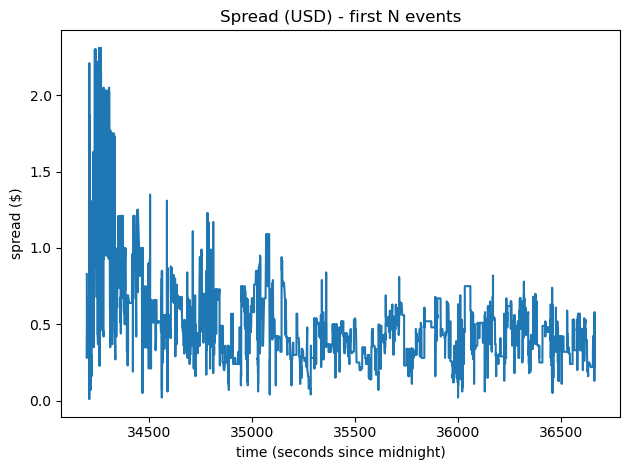

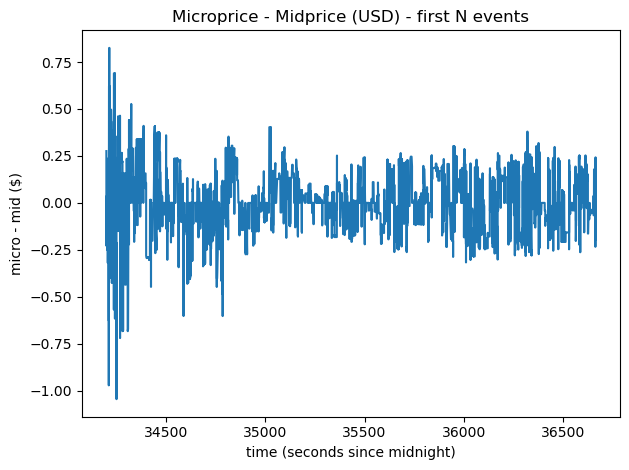

In [5]:
# Plot only a slice for speed
N = 20_000

df["spread_d"].head(N).plot(title="Spread (USD) - first N events")
plt.xlabel("time (seconds since midnight)")
plt.ylabel("spread ($)")
plt.tight_layout()
plt.show()

(df["micro_d"] - df["mid_d"]).head(N).plot(title="Microprice - Midprice (USD) - first N events")
plt.xlabel("time (seconds since midnight)")
plt.ylabel("micro - mid ($)")
plt.tight_layout()
plt.show()


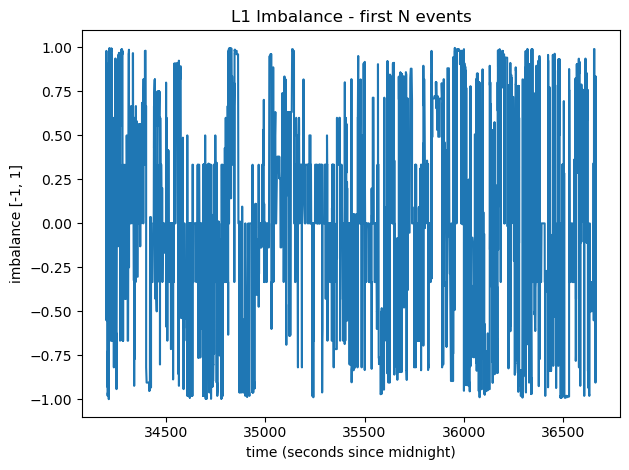

In [6]:
df["imbalance_l1"].head(N).plot(title="L1 Imbalance - first N events")
plt.xlabel("time (seconds since midnight)")
plt.ylabel("imbalance [-1, 1]")
plt.tight_layout()
plt.show()
